In [10]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt

# Data processing (Task 1)

In [2]:
load_dotenv()
filepath = os.getenv('FILEPATH')
print(f"Filepath: {filepath}") 


Filepath: data/news_cleaned_2018_02_13.csv


### Calculating precentage of rows

In [22]:
sample = pd.read_csv(filepath, nrows=1000, usecols=["content"])
sample_size_MB = sample.memory_usage(deep=True).sum() / (1024**2)
avg_MB_per_row = sample_size_MB / 1000

total_size_MB = 30 * 1024  # 30 GB in MB
estimated_total_rows = int(total_size_MB / avg_MB_per_row)

rows_10_percent = int(estimated_total_rows * 0.10)
print(f"10% of dataset ≈ {rows_10_percent} rows")

10% of dataset ≈ 538681 rows


In [ ]:
"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(10**9)
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# using 100 000 rows for building the data processing for now, this is just for testing to download the data 
df_iterator = pd.read_csv(filepath, nrows=100000, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=100000)

df = next(df_iterator) # first chunk
print(df.head()) 

# Load the CSV file in chunks of 100000 rows
# chunks = []
# for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=500000, on_bad_lines='warn', engine='python'):
#    chunks.append(chunk)
# df = pd.concat(chunks, ignore_index=True)


#for i, chunk in enumerate(df_iter):
#    df = pd.concat([df, chunk], ignore_index=True)
#    print(f"Chunk {i+1}:")
#    print(chunk.head())  # Printing first 5 rows of each chunk

               domain   type  \
0       express.co.uk  rumor   
1  barenakedislam.com   hate   
2  barenakedislam.com   hate   
3  barenakedislam.com   hate   
4  barenakedislam.com   hate   

                                                 url  \
0  https://www.express.co.uk/news/science/738402/...   
1  http://barenakedislam.com/category/donald-trum...   
2  http://barenakedislam.com/category/donald-trum...   
3  http://barenakedislam.com/2017/12/24/more-winn...   
4  http://barenakedislam.com/2017/12/25/oh-trump-...   

                                             content  \
0  Life is an illusion, at least on a quantum lev...   
1  Unfortunately, he hasn’t yet attacked her for ...   
2  The Los Angeles Police Department has been den...   
3  The White House has decided to quietly withdra...   
4  “The time has come to cut off the tongues of t...   

                                               title  \
0  Is life an ILLUSION? Researchers prove 'realit...   
1                    

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
output_file = "processed_data.txt"

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()

# I used chatgpt here for understanding how to use spacy and processing the texts in batches
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=200): 

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopwword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

first_chunk = True
# writing the processed text data into another file
with open(output_file, "w", encoding="utf-8") as f_out: 
    for chunk in pd.read_csv(filepath, nrows=1000, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=200, engine='python'):
        start = time.time() # timing the chunk processing for debugging

        chunk["processed_text"] = list(preprocess(chunk["content"].astype(str))) # collecting yields into a list

        print(f"Chunk processed in {time.time() - start:.2f}s")
        # appending the chunk to the output file
        chunk[["processed_text", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
        first_chunk = False # for the header 


print("Preprocessing done.")

Chunk processed in 14.70s
Chunk processed in 10.39s
Chunk processed in 8.33s
Chunk processed in 11.84s
Chunk processed in 9.65s
Preprocessing done.


### Computing reduction rates

In [8]:
original_vocab_size = len(original_vocab) 
filtered_vocab_size = len(filtered_vocab_counter)
lemmatized_vocab_size = len(lemmatized_vocab_counter)

# reduction rate after stopword removal
stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

# calculating elmamtized reduction rate
lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

print(f"Original vocabulary size: {original_vocab_size}")
print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

df = pd.read_csv(output_file)
print(df.head())    



Original vocabulary size: 25617
Vocabulary size after removing stopwords: 25323
Vocabulary size after lemmatization: 20319
Stopword reduction rate: 1.15%
lemmatized reduction rate: 19.76%
                                      processed_text   type  \
0  life illusion quantum level theory recently co...  rumor   
1  unfortunately attack islamic terrorism connect...   hate   
2  los angeles police department deny million fed...   hate   
3  white house decide quietly withdraw tie ramall...   hate   
4  time come cut tongue support peace mourn disag...   hate   

               domain                                              title  \
0       express.co.uk  Is life an ILLUSION? Researchers prove 'realit...   
1  barenakedislam.com                                       Donald Trump   
2  barenakedislam.com                                       Donald Trump   
3  barenakedislam.com  MORE WINNING! Israeli intelligence source, DEB...   
4  barenakedislam.com  “Oh, Trump, you coward, you ju

### Exploring data

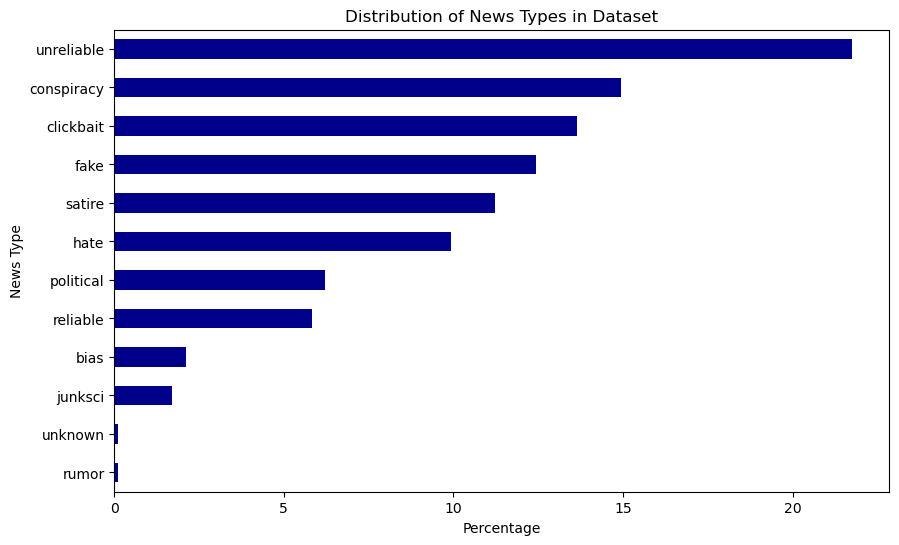

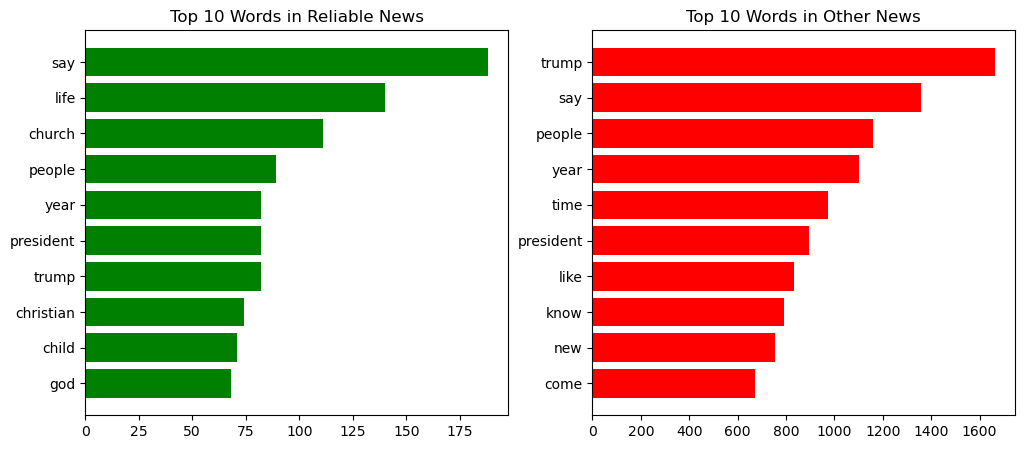

In [21]:
   
# Precentage distribution of labels in the datasetr
type_distribution = df["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

# visualizing the distribution of words in reliable vs non-reliable news
reliable_texts = df[df["type"] == "reliable"]["processed_text"]
other_texts = df[df["type"] != "reliable"]["processed_text"]

reliable_counter = Counter(" ".join(reliable_texts).split())
other_counter = Counter(" ".join(other_texts).split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(10)
other_top10 = other_counter.most_common(10)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()